<a href="https://colab.research.google.com/github/vkislinskii/m606_house_prices_prediction/blob/main/project_real_estate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sklearn.model_selection
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, spmatrix
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 8})

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/2025Q1_Machine_learning_m606b/m606_project_melbourne_housing_full.csv")
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.50,3067.00,2.00,1.00,1.00,126.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
1,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,2.00,1.00,1.00,202.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
2,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,4/02/2016,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.50,3067.00,3.00,2.00,1.00,0.00,NaN,NaN,Yarra City Council,-37.81,145.01,Northern Metropolitan,4019.00
4,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00


#3. Data exprolarion and preprocessing

##3.1. Data exploration functions defining

In [ ]:
#high-level overview
def data_exploration_1_overall(df):
  shape = f"{df.shape[0]} - number of rows\n{df.shape[1]} - number of columns\n"
  summary = pd.DataFrame({
    "Data Type": df.dtypes,
    "Missing Values": df.isnull().sum()
    })
  return shape, summary

In [ ]:
#creating histograms and descriptive statistics for numerical columns
def data_exploration_2_nums(df):
  num_attr = df.select_dtypes(include=['int64', 'float64']).columns
  df.hist(figsize=(12,12), layout=(4,4), sharex=False)
  plt.show()
  display(df[num_attr].describe())

In [ ]:
#creating barplots for categorical columns
def data_exploration_2_cats(df):
  cat_attr = df.select_dtypes(include='object').columns
  n_columns = len(cat_attr)
  n_rows = np.ceil(n_columns / 4).astype(int)
  fig, axes = plt.subplots(n_rows, 4, figsize=(12, n_rows * 2.5))
  axes = axes.flatten()
  for i, col in enumerate(cat_attr):
    value_counts = df[col].value_counts()
    total_count = len(df)

    # If there are more than 20 unique values, take only the top 10
    if len(value_counts) > 20:
      value_counts = value_counts.head(10)

    share = (value_counts / total_count) * 100
    sns.barplot(y=value_counts.index, x=share.values, ax=axes[i])
    axes[i].set_title(f'Share for {col}')
    axes[i].set_ylabel('')

  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
#splitting features and target
def split_dfs(df, target_col):
  y = df[target_col]
  x = df.drop(target_col, axis=1)
  return x, y

##3.2. Basic data exploration

In [ ]:
a, b = data_exploration_1_overall(df)
print(a)
b

34857 - number of rows
21 - number of columns



,Data Type,Missing Values
Suburb,object,0
Address,object,0
Rooms,int64,0
Type,object,0
Price,float64,7610
Method,object,0
SellerG,object,0
Date,object,0
Distance,float64,1
Postcode,float64,1


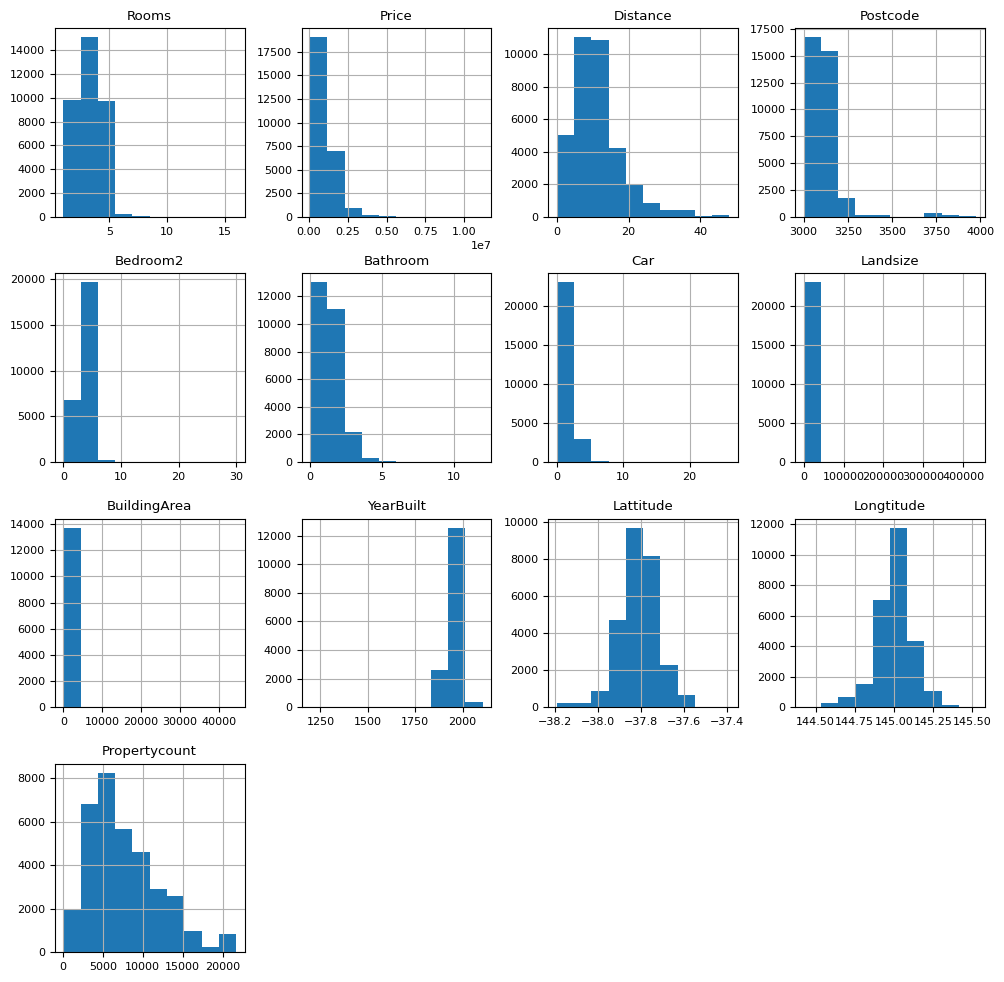

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.00,27247.00,34856.00,34856.00,26640.00,26631.00,26129.00,23047.00,13742.00,15551.00,26881.00,26881.00,34854.00
mean,3.03,1050173.34,11.18,3116.06,3.08,1.62,1.73,593.60,160.26,1965.29,-37.81,145.00,7572.89
std,0.97,641467.13,6.79,109.02,0.98,0.72,1.01,3398.84,401.27,37.33,0.09,0.12,4428.09
min,1.00,85000.00,0.00,3000.00,0.00,0.00,0.00,0.00,0.00,1196.00,-38.19,144.42,83.00
25%,2.00,635000.00,6.40,3051.00,2.00,1.00,1.00,224.00,102.00,1940.00,-37.86,144.93,4385.00
50%,3.00,870000.00,10.30,3103.00,3.00,2.00,2.00,521.00,136.00,1970.00,-37.81,145.01,6763.00
75%,4.00,1295000.00,14.00,3156.00,4.00,2.00,2.00,670.00,188.00,2000.00,-37.75,145.07,10412.00
max,16.00,11200000.00,48.10,3978.00,30.00,12.00,26.00,433014.00,44515.00,2106.00,-37.39,145.53,21650.00


In [ ]:
data_exploration_2_nums(df)

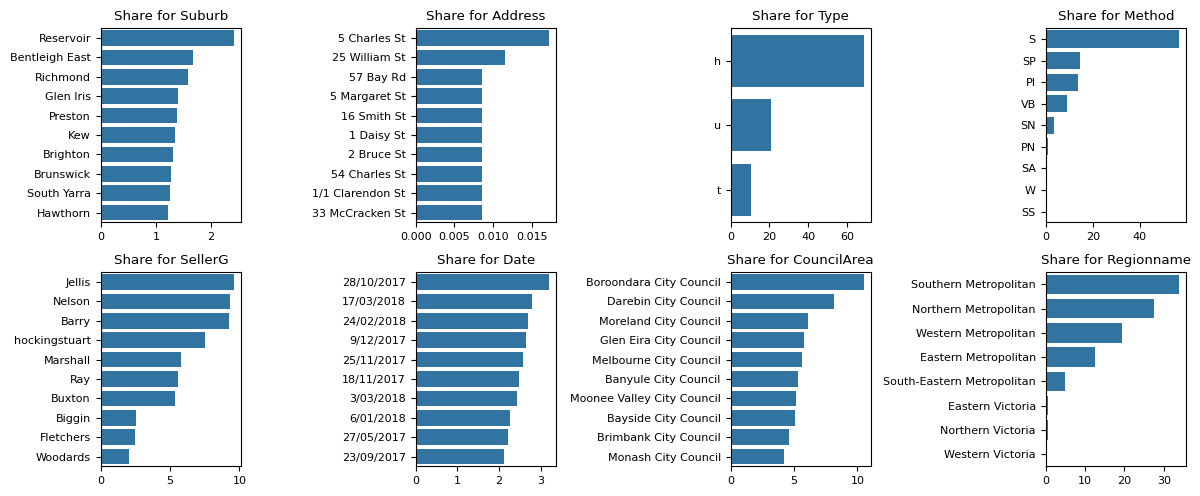

In [ ]:
data_exploration_2_cats(df)

##3.3. Detailed exprolarion and preprocessing

In [ ]:
#what are logic behind null price observations? how are the null price rows connected with sales method (column 'Method')
df['got_price'] = np.where(df['Price'] == df['Price'], 1, 0)
df[['Method', 'got_price', 'Address']].groupby(['Method', 'got_price']).count()

#Conclusion: remove all rows with null price value
#it's understandable to have no price in some methods: PN (sold prior not disclosed), SN (sold not disclosed), SS (sold after auction price not disclosed), W (withdrawn prior to auction)
#but for another sale methods (for example S (property sold), SA (sold after auction)) it's not clear why we don't have Price

Address
Method got_price         
PI     0             1595
       1             3255
PN     0              308
S      0             2229
       1            17515
SA     0               36
       1              190
SN     0             1317
SP     0             1492
       1             3603
SS     0               36
VB     0              424
       1             2684
W      0              173

In [ ]:
# removing the rows with null price value and 'got_price' column (we don't need it no more)
df = df.query('Price == Price')
df = df.drop(['got_price'], axis=1)

In [ ]:
#what are the cheapest objects (that are below the 5th percentile for 'Price' feature)? do that entities look ok or it is an error and we need to remove them?
price_percentile5 = df['Price'].quantile(0.05) #.query('Price')
df.query('Price <= @price_percentile5').sort_values('Price').head()

#Conslusion
#overall this rows look fine, so we can keep them

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
4378,Footscray,202/51 Gordon St,1,u,85000.00,PI,Burnham,3/09/2016,6.40,3011.00,1.00,1.00,0.00,0.00,NaN,2007.00,Maribyrnong City Council,-37.79,144.89,Western Metropolitan,7570.00
29669,Malvern East,114/141 Waverley Rd,1,u,112000.00,S,C21,6/01/2018,8.40,3145.00,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,8801.00
17529,East Melbourne,515/133 Jolimont Rd,1,u,121000.00,PI,Dixon,8/07/2017,1.30,3002.00,NaN,NaN,NaN,NaN,NaN,NaN,Melbourne City Council,NaN,NaN,Northern Metropolitan,3040.00
3063,Caulfield,30 Pyne St,4,h,131000.00,PI,Rodney,25/02/2017,8.90,3162.00,4.00,1.00,2.00,499.00,155.00,1920.00,Glen Eira City Council,-37.89,145.02,Southern Metropolitan,2379.00
11859,Albion,8/6 Ridley St,1,u,145000.00,PI,Biggin,28/05/2016,13.90,3020.00,2.00,1.00,1.00,36.00,NaN,NaN,Brimbank City Council,-37.78,144.83,Western Metropolitan,2185.00


In [ ]:
#what are the most expensive objects (that are in the 95th percentile for 'Price' label)? does that entities look ok or it is an error and we need to remove them?
price_percentile95 = df['Price'].quantile(0.95)
df.query('Price >= @price_percentile95').sort_values('Price', ascending=False).head()

#Conslusion
#overall this rows look fine, so we can keep them

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
25635,Brighton,6 Cole St,4,h,11200000.00,VB,hockingstuart,28/10/2017,10.50,3186.00,4.00,3.00,2.00,1400.00,NaN,NaN,Bayside City Council,-37.89,144.99,Southern Metropolitan,10579.00
19583,Mulgrave,35 Bevis St,3,h,9000000.00,PI,Hall,29/07/2017,18.80,3170.00,3.00,1.00,1.00,744.00,117.00,1960.00,Monash City Council,-37.93,145.16,South-Eastern Metropolitan,7113.00
12539,Canterbury,49 Mangarra Rd,5,h,8000000.00,VB,Sotheby's,13/05/2017,9.00,3126.00,5.00,5.00,4.00,2079.00,464.30,1880.00,Boroondara City Council,-37.82,145.07,Southern Metropolitan,3265.00
15696,Hawthorn,49 Lisson Gr,4,h,7650000.00,S,Abercromby's,17/06/2017,5.30,3122.00,4.00,2.00,4.00,1690.00,284.00,1863.00,Boroondara City Council,-37.83,145.03,Southern Metropolitan,11308.00
28334,Armadale,1 Barnato Gr,4,h,7000000.00,PI,Kay,25/11/2017,6.30,3143.00,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,4836.00


In [ ]:
#do we really have objects with a lot of rooms (that are in the 95th percentile for 'Rooms' column)? does that entities look ok or we need to remove them?
room_percentile95 = df['Rooms'].quantile(0.95)
df.query('Rooms >= @room_percentile95').sort_values('Rooms', ascending=False).head(5)

#Conclusion
#house #27150 is relatively cheap for that number of rooms, but another logically connected columns (Bedroom2, Bathroom, Car) have relevant values, so it seems to be ok
#overall everything looks fine

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
26210,Mitcham,20 Harrison St,16,h,5000000.00,S,Buxton,28/10/2017,17.20,3132.00,16.00,8.00,8.00,NaN,NaN,NaN,Whitehorse City Council,-37.81,145.20,Eastern Metropolitan,6871.00
27150,Melton,213 Station Rd,12,h,710000.00,S,PRDNationwide,11/11/2017,31.70,3337.00,12.00,5.00,3.00,960.00,223.00,1970.00,Melton City Council,-37.69,144.58,Western Victoria,3600.00
12959,Hawthorn,10 Berkeley St,12,h,4700000.00,PI,Property,20/05/2017,4.60,3122.00,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,-37.83,145.04,Southern Metropolitan,11308.00
2613,Burwood,445 Warrigal Rd,10,h,1960000.00,S,Kay,27/11/2016,11.70,3125.00,NaN,NaN,NaN,NaN,NaN,NaN,Monash City Council,-37.86,145.09,Southern Metropolitan,5678.00
18443,Bundoora,5 Ball Ct,10,h,900000.00,PI,Ray,15/07/2017,12.10,3083.00,10.00,3.00,2.00,313.00,NaN,2006.00,Banyule City Council,-37.71,145.05,Northern Metropolitan,10175.00


In [ ]:
# what is a row with null value in 'Distance' and 'Postcode' features? should I remove it ro replace with smth?
df[df.Distance != df.Distance]

#Conclusion
#this row has nulls in many columns, it should be just some issues with the data collection
#we don't have reason how to better impute this data (there are no other objects in 'Fawkner Lot' suburb), so overall it's better to delete this row, it will no little impact on our ml pipeline

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
29483,Fawkner Lot,1/3 Brian St,3,h,616000.00,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#removing the rows with null 'Distance' value
df = df.drop(29483)

In [ ]:
# how that's possible, that object has more bedrooms (column 'Bedroom2') than rooms in general (column 'Rooms')?
df[df.Bedroom2 > df.Rooms].head(5)

#Conclusion
#overall I will delete the rows where df.Bedroom2 > df.Rooms (221 rows) and then I will try two options: firstly I will train ml model with using this column
#secondly, I will try to remove the column entirely

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
11,Abbotsford,124 Yarra St,3,h,1876000.00,S,Nelson,7/05/2016,2.50,3067.00,4.00,2.00,0.00,245.00,210.00,1910.00,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
18,Abbotsford,10 Valiant St,2,h,1097000.00,S,Biggin,8/10/2016,2.50,3067.00,3.00,1.00,2.00,220.00,75.00,1900.00,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
106,Airport West,6 Kittyhawk St,4,h,773000.00,S,Brad,17/09/2016,13.50,3042.00,5.00,3.00,4.00,531.00,309.00,1980.00,Moonee Valley City Council,-37.73,144.87,Western Metropolitan,3464.00
340,Altona North,1/156 Chambers Rd,3,h,620000.00,SP,Hunter,22/08/2016,11.10,3025.00,5.00,2.00,2.00,276.00,100.00,2010.00,Hobsons Bay City Council,-37.83,144.84,Western Metropolitan,5132.00
387,Armadale,11/17 Myamyn St,2,u,3625000.00,S,Jellis,4/06/2016,6.30,3143.00,3.00,2.00,2.00,0.00,NaN,2006.00,Stonnington City Council,-37.86,145.03,Southern Metropolitan,4836.00


In [ ]:
df = df.drop(df[df.Bedroom2 > df.Rooms].index)

In [ ]:
#what is a rows with null values in 'Bedroom2' feature? should I remove it ro replace with smth?
df[df.Bedroom2 != df.Bedroom2].head(5)

#Conclusion
#all seems to be ok. it looks like just not all of the entities were scapped equally and it is the reason why we have a lot of nulls in the column 'Bedroom2'
#p.s. also a lot of the null values have columns 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', but generally rows with these features look fine.
#we cannot train sklearn regression models on null features, so I will try to impute null values with midean values and KNNImputer

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
15,Abbotsford,217 Langridge St,3,h,1000000.00,S,Jellis,8/10/2016,2.50,3067.00,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.00
16,Abbotsford,18a Mollison St,2,t,745000.00,S,Jellis,8/10/2016,2.50,3067.00,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.00
19,Abbotsford,403/609 Victoria St,2,u,542000.00,S,Dingle,8/10/2016,2.50,3067.00,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.00
21,Abbotsford,25/84 Trenerry Cr,2,u,760000.00,SP,Biggin,10/12/2016,2.50,3067.00,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.00
22,Abbotsford,106/119 Turner St,1,u,481000.00,SP,Purplebricks,10/12/2016,2.50,3067.00,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.00


In [ ]:
#what are the objects in the 95th percentile for 'Bathroom' feature? does that entities look ok or it is an error and we need to remove them?
bath_percentile95 = df['Bathroom'].quantile(0.95)
df.query('Bathroom >= @bath_percentile95').sort_values('Bathroom', ascending=False).head()

#Conslusion
#overall values of this column look quite strange. it's strange to have that amount of bathrooms in a house: 9 bathrooms for 9 rooms doesn't make a lot of sence

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
25717,Burwood,79 Elgar Rd,10,h,2315000.00,SP,Buxton,28/10/2017,10.40,3125.00,10.00,9.00,2.00,612.00,466.00,2015.00,Monash City Council,-37.84,145.11,Southern Metropolitan,5678.00
17472,Camberwell,1088 Toorak Rd,8,h,2200000.00,PI,Ross,8/07/2017,7.70,3124.00,8.00,8.00,4.00,650.00,NaN,NaN,Boroondara City Council,-37.85,145.07,Southern Metropolitan,8920.00
26210,Mitcham,20 Harrison St,16,h,5000000.00,S,Buxton,28/10/2017,17.20,3132.00,16.00,8.00,8.00,NaN,NaN,NaN,Whitehorse City Council,-37.81,145.20,Eastern Metropolitan,6871.00
1004,Balwyn,29 Sevenoaks St,5,h,3900000.00,PI,Jellis,28/08/2016,9.70,3103.00,5.00,7.00,6.00,0.00,NaN,NaN,Boroondara City Council,-37.80,145.07,Southern Metropolitan,5682.00
25746,Camberwell,54 Radnor St,7,h,5450000.00,S,Marshall,28/10/2017,7.70,3124.00,7.00,6.00,5.00,NaN,453.00,1920.00,Boroondara City Council,-37.84,145.06,Southern Metropolitan,8920.00


In [ ]:
#do we have cases when object have more bathrooms, than rooms in general?
df[df.Bathroom > df.Rooms].head()

#Conclusion
#overall this cases look quite strange. I will try two options: firstly I will train ml model with using this column
#secondly, I will try to remove the column entirely

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
756,Avondale Heights,6 Lovett Dr,4,h,1200000.00,S,Nelson,4/06/2016,10.50,3034.00,4.00,5.00,4.00,673.00,NaN,NaN,Moonee Valley City Council,-37.75,144.87,Western Metropolitan,4502.00
947,Balwyn,49 Metung St,5,h,3400000.00,VB,Jellis,18/06/2016,9.70,3103.00,5.00,6.00,4.00,739.00,502.00,NaN,Boroondara City Council,-37.80,145.07,Southern Metropolitan,5682.00
1004,Balwyn,29 Sevenoaks St,5,h,3900000.00,PI,Jellis,28/08/2016,9.70,3103.00,5.00,7.00,6.00,0.00,NaN,NaN,Boroondara City Council,-37.80,145.07,Southern Metropolitan,5682.00
3446,Coburg,40 Elizabeth St,1,h,1007000.00,SP,Brad,28/08/2016,7.80,3058.00,1.00,2.00,0.00,807.00,1.00,NaN,Darebin City Council,-37.74,144.98,Northern Metropolitan,11204.00
4256,Fitzroy North,186 Queens Pde,2,t,930000.00,S,Nelson,3/09/2016,3.50,3068.00,2.00,3.00,0.00,2778.00,3558.00,NaN,Moreland City Council,-37.79,144.99,Northern Metropolitan,6244.00


In [ ]:
#what are the objects in the 95th percentile for 'Car' feature? does that entities look ok or it is an error and we need to remove them?
car_percentile95 = df['Car'].quantile(0.95)
df.query('Car >= @car_percentile95').sort_values('Car', ascending=False).head()

#Conslusion
#overall values of this column look strange (just like the 'Bedroom2' and 'Bathroom' values). how can a house have 2 rooms, but 18 parking spots? I will try to remove this feature and see how it will impact the result.

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
25839,Croydon,26 Railway Cr,2,h,1105000.00,SP,iTRAK,28/10/2017,23.00,3136.00,2.00,1.00,18.00,1250.00,NaN,NaN,Maroondah City Council,-37.79,145.29,Eastern Metropolitan,11925.00
32862,St Albans,11 Magnus St,4,h,788000.00,S,Ray,17/02/2018,14.00,3021.00,4.00,2.00,11.00,697.00,NaN,NaN,Brimbank City Council,-37.76,144.80,Western Metropolitan,14042.00
30482,Hoppers Crossing,4 Redwood Dr,3,h,780000.00,SP,Greg,9/12/2017,18.40,3029.00,3.00,2.00,10.00,NaN,NaN,1988.00,Wyndham City Council,-37.86,144.70,Western Metropolitan,13830.00
23395,Reservoir,1 Don St,4,h,1112000.00,S,RW,26/08/2017,12.00,3073.00,4.00,2.00,10.00,1002.00,170.00,1985.00,Darebin City Council,-37.71,145.03,Northern Metropolitan,21650.00
29910,Sunshine West,47 Bardsley St,5,h,990000.00,PI,Douglas,6/01/2018,10.50,3020.00,5.00,2.00,10.00,980.00,NaN,NaN,Brimbank City Council,-37.79,144.82,Western Metropolitan,6763.00


In [ ]:
#how is the feature 'Landsize' connected with real estate type (column 'Type')?
df[['Type', 'Landsize']].groupby('Type').agg({'Landsize': ['min', 'max', 'median']})

#Conclusion
#all data looks quite logical: units and duplexes majorly have no extra land included, townhouses have some space, and houses have more space. and also it looks logical, that some of objects of all types has no included land.

Landsize                 
          min       max median
Type                          
h        0.00 433014.00 575.00
t        0.00  15900.00 209.00
u        0.00  37000.00   0.00

In [ ]:
# how is the feature 'BuildingArea' connected with real estate type (column 'Type')?
df[['Type', 'BuildingArea']].groupby('Type').agg({'BuildingArea': ['min', 'max', 'median']})

#Conclusion
#median values look logical: units and duplexes majorly have smallest building size, townhouses have more, and houses have largest building size.

BuildingArea                
              min      max median
Type                             
h            0.00 44515.00 147.00
t            0.00  6178.00 131.00
u            0.00   999.00  75.00

In [ ]:
# what are the objects with zero BuildingArea? how it's even possible for a real estate to have no building size?
df[df.BuildingArea == 0].head()

#Conclusion
#overall this cases look quite strange. I believe it's better to drop this 61 row with 0 in 'BuildingArea' column

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
7211,North Melbourne,19 Shands La,2,t,841000.00,S,Jellis,4/03/2017,2.30,3051.00,2.00,1.00,1.00,215.00,0.00,2000.00,Melbourne City Council,-37.80,144.94,Northern Metropolitan,6821.00
19775,Balwyn North,14 Wanbrow Av,5,h,1950000.00,S,RT,3/09/2017,9.70,3104.00,5.00,3.00,2.00,743.00,0.00,1949.00,Boroondara City Council,-37.80,145.09,Southern Metropolitan,7809.00
19840,Bundoora,22 Moreton Cr,3,h,814000.00,S,Barry,3/09/2017,12.10,3083.00,3.00,1.00,2.00,542.00,0.00,1970.00,Banyule City Council,-37.71,145.06,Northern Metropolitan,10175.00
20223,Roxburgh Park,16 Sandover Dr,4,h,570000.00,S,Raine,3/09/2017,20.60,3064.00,4.00,2.00,2.00,504.00,0.00,2000.00,Hume City Council,-37.61,144.93,Northern Metropolitan,5833.00
20262,Thornbury,19/337 Station St,3,t,900000.00,VB,Jellis,3/09/2017,7.00,3071.00,3.00,2.00,2.00,120.00,0.00,2000.00,Darebin City Council,-37.76,145.02,Northern Metropolitan,8870.00


In [ ]:
#dropping the houses with zero BuildingArea
df = df.drop(df[df.BuildingArea == 0].index)

In [ ]:
df.shape

(26964, 21)

In [ ]:
# what are the objects below the 5th percentile for 'YearBuilt' feature? do we really have house built in 1196? do that entities look ok or it is an error and we need to remove them?
year_percentile05 = df['YearBuilt'].quantile(0.05)
df.query('YearBuilt <= @year_percentile05').sort_values('YearBuilt', ascending=True).head()

#Conclusion
#house on 5 Armstrong St definetely couldn't be built in 1196, because the city of Melbourne was founded in 1835. I will drop this row

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
16424,Mount Waverley,5 Armstrong St,3,h,1200000.00,VB,McGrath,24/06/2017,14.20,3149.00,3.00,1.00,4.00,807.00,117.00,1196.00,Monash City Council,-37.87,145.12,Eastern Metropolitan,13366.00
25762,Carlton North,146 Pigdon St,2,u,720000.00,S,Jellis,28/10/2017,3.50,3054.00,2.00,1.00,NaN,NaN,64.00,1820.00,Melbourne City Council,-37.78,144.97,Northern Metropolitan,3106.00
3533,Collingwood,2/79 Oxford St,2,u,855000.00,S,Nelson,3/09/2016,1.60,3066.00,2.00,1.00,1.00,2886.00,122.00,1830.00,Yarra City Council,-37.80,144.98,Northern Metropolitan,4553.00
8030,Prahran,602/220 Commercial Rd,2,u,841000.00,S,hockingstuart,18/03/2017,4.50,3181.00,2.00,2.00,1.00,0.00,101.00,1850.00,Stonnington City Council,-37.85,144.99,Southern Metropolitan,7717.00
8935,Richmond,22a Stanley St,3,h,1600000.00,S,Biggin,24/09/2016,2.60,3121.00,3.00,2.00,2.00,80.00,144.00,1850.00,Yarra City Council,-37.82,144.99,Northern Metropolitan,14949.00


In [ ]:
df = df.drop(16424)

In [ ]:
# 4what are the rows with null values in 'CouncilArea', 'Regionname' and 'Propertycount' features? should I remove it ro replace with smth?
df[df.Propertycount != df.Propertycount]

#Conclusion
#I will drop this two rows. Because it's only 2 rows, they will not have a huge impact

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
18523,Footscray,2/16 Stafford St,2,u,710000.00,S,Jas,15/07/2017,5.10,3011.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26888,Camberwell,2/3 Kingsley St,2,h,825000.00,VB,Jellis,11/11/2017,7.70,3124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.drop([18523, 26888])

array([[<Axes: title={'center': 'Date'}>]], dtype=object)

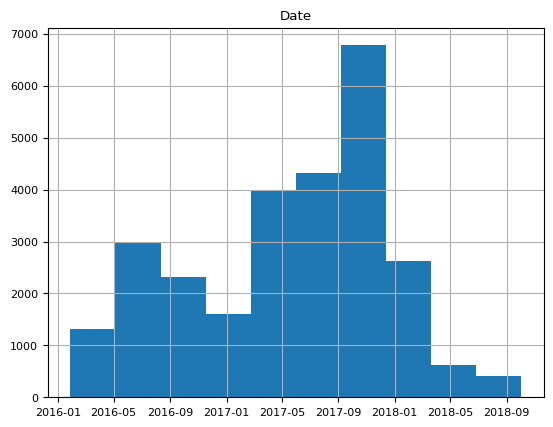

In [ ]:
# 3what are all the possible values in column 'Date'? we need to change the data type to real date, not 'object'
df['Date'] = df['Date'].astype('datetime64[ns]')
df[['Date']].hist()

#Conclusion
#data in column looks good

In [ ]:
#check how many unique adresses we have
df.Address.nunique()

#Conclusion
#almost all of the adresses are unique. we need to drop this column, it's too many string values to do one-hot encoding

26476

In [ ]:
#drop the entire Address column
df = df.drop(['Address'], axis=1)

In [ ]:
#converte Postcode to a string for better training
df['Postcode'] = df['Postcode'].astype('str')

#4. Feature engineering

##4.1. Feature engineering functions defining

In [ ]:
# in - df, out - sparse matrix
def standartization(train, test, type, cat_scaler, num_scaler1):
  num_attr = train.select_dtypes(include=['int64', 'float64']).columns
  cat_attr = train.select_dtypes(include='object').columns

  if type == 'both':
    ct = sklearn.compose.ColumnTransformer([
      ('pipeline', num_scaler1, num_attr),
      ('one_hot_encoder', cat_scaler, cat_attr)
    ])
  elif type == 'cats':
    ct = sklearn.compose.ColumnTransformer([
      ("pass", "passthrough", num_attr),
      ('one_hot_encoder', cat_scaler, cat_attr)
    ])
  ct = ct.fit(train)
  matrix_train = ct.transform(train)
  matrix_test = ct.transform(test)

  return matrix_train, matrix_test

In [ ]:
# in - df, out - sparse matrix
def standartization_target(train, test, num_scaler1):
  scaler = num_scaler1

  scaler = scaler.fit(train.to_frame())
  matrix_train = scaler.transform(train.to_frame())
  matrix_test = scaler.transform(test.to_frame())

  return matrix_train, matrix_test, scaler.mean_, scaler.scale_

In [ ]:
#in - sparse matrix, out - array
def dimension_reduction(train, test, method):
  method = method
  if isinstance(train, spmatrix):
    method.fit(train.toarray())
    out_train = method.transform(train.toarray())
    out_test = method.transform(test.toarray())
  return out_train, out_test, method

##4.2. Feature engineering

In [ ]:
#taking logarithm on label column
df['Price'] = np.log(df['Price'])

In [ ]:
#splitting train-test, splitting features-target
train_df, test_df = sklearn.model_selection.train_test_split(df, random_state=42)

In [ ]:
#filling the null values
train_df_numeric = train_df.select_dtypes(include=np.number).copy()
test_df_numeric = test_df.select_dtypes(include=np.number).copy()

imputer = sklearn.impute.KNNImputer(n_neighbors=5)
train_df_numeric_imputed = imputer.fit_transform(train_df_numeric)
test_df_numeric_imputed = imputer.transform(test_df_numeric)

train_df[train_df_numeric.columns] = train_df_numeric_imputed
test_df[test_df_numeric.columns] = test_df_numeric_imputed

In [ ]:
#splitting x and y
x_train, y_train = split_dfs(train_df, 'Price')
x_test, y_test = split_dfs(test_df, 'Price')

In [ ]:
#performing one-hot encoding (and only it performs with 'cats' parameter)
x_train, x_test = standartization(x_train, x_test, 'cats', sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"), sklearn.preprocessing.StandardScaler())

#5. Models selection

In [ ]:
models = {
    "LinearRegression": sklearn.linear_model.LinearRegression(),
    "ElasticNet": sklearn.linear_model.ElasticNet(random_state=42, selection='random'),
    #"SVR": sklearn.svm.SVR(),
    "KNN": sklearn.neighbors.KNeighborsRegressor(),
    "DecisionTree": sklearn.tree.DecisionTreeRegressor(random_state=42),
    "RandomForest": sklearn.ensemble.RandomForestRegressor(random_state=42),
    "GradientBoosting": sklearn.ensemble.GradientBoostingRegressor(random_state=42)
}

param_distributions = {
    "LinearRegression": {},
    "ElasticNet": {
        "alpha": [0.1, 1, 10],
        "l1_ratio": [0.1, 0.5, 1]
    },
    "SVR": {
        "C": [1, 10],
        "kernel": ["linear", "rbf"]
    },
    "KNN": {
        "n_neighbors": [3, 7, 10, 15, 20],
        "weights": ['uniform', 'distance']
    },
    "DecisionTree": {
        "max_depth": [10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5]
    },
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20],
        "min_samples_split": [5, 10]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.2, 0.5]
    }
}

#6. Model training

In [ ]:
#to evaluate transformed target correctly, it is needed to create custom scoring metric
def exp_median_absolute_error(y_true, y_pred_log):
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_true)
    return sklearn.metrics.median_absolute_error(y_true, y_pred)

custom_scorer = sklearn.metrics.make_scorer(exp_median_absolute_error, greater_is_better=False)

#loop through the models and hyperparameters to choose the best one
best_models = {}
for model_name, model in models.items():
    print(f"Searching for {model_name}...")

    random_search = sklearn.model_selection.RandomizedSearchCV(
        model,
        param_distributions[model_name],
        n_iter=7,
        cv=4,
        scoring=custom_scorer,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(x_train, y_train)

    # Store the best model
    best_models[model_name] = {
        "best_estimator": random_search.best_estimator_,
        "best_score": random_search.best_score_,
        "best_params": random_search.best_params_
    }
    print(f"The best score for {model_name} is {random_search.best_score_}")

# Identify the best overall model
best_model_name = max(best_models, key=lambda k: best_models[k]["best_score"])
best_model = best_models[best_model_name]["best_estimator"]

print(f"\nBest Model: {best_model_name}")
print(f"Best Model's Score: {best_models[best_model_name]['best_score']}")
print(f"Best Parameters: {best_models[best_model_name]['best_params']}")

Searching for LinearRegression...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=7. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


The best score for LinearRegression is -120990.33972516493
Searching for ElasticNet...
The best score for ElasticNet is -164614.1181084948
Searching for KNN...
The best score for KNN is -117386.71416965271
Searching for DecisionTree...
The best score for DecisionTree is -111441.09300202788
Searching for RandomForest...
The best score for RandomForest is -83714.83841082359
Searching for GradientBoosting...
The best score for GradientBoosting is -91890.51806074126

Best Model: RandomForest
Best Model's Score: -83714.83841082359
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 20}


In [ ]:
#training the model on the full training and validation dataset
best_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [ ]:
#evaluate the model on the testing data
y_pred_log_test = best_model.predict(x_test)
y_pred_test = np.exp(y_pred_log_test)
y_true_test = np.exp(y_test)

medae = sklearn.metrics.median_absolute_error(y_true_test, y_pred_test)
mape = sklearn.metrics.mean_absolute_percentage_error(y_true_test, y_pred_test)
r2 = sklearn.metrics.r2_score(y_true_test, y_pred_test)

# Print the evaluation metrics
print(f"Median Absolute Error (MedAE): {medae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}")
print(f"R² Score: {r2:.3f}")

Median Absolute Error (MedAE): 82333.166
Mean Absolute Percentage Error (MAPE): 0.134
R² Score: 0.824
